# Recurrent Neural Networks (RNN)


As explained in the [notes](./rnn.md), Recurrent Neural Networks (RNNs) are a type of neural network that is designed to work with sequential data. Unlike traditional neural networks, RNNs have a 'memory' that allows them to persist information from previous inputs in the sequence. As languages tend to be sequential in _at least_ writing (i.e., so either LTR or RTL), this means that _technically_, linguistics is really just a sequence predicition problem (i.e., time-series, or whatever).


## Setup

You can just ignore this bit.


In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import trange
import torch.nn as nn
import numpy as np
import random
import torch

## Data Gen

For this notebook, we'll work with a simple test case, this is _kinda_ like a simplified [needle-in-a-haystack](https://github.com/gkamradt/LLMTest_NeedleInAHaystack) problem, where the actual substantial token is placed at index 0, and then we pad with filler all the way until `seq_len`. What this does is that, if the gradient doesn't flow well (as is in the case of simple RNNs), the BPTT gradient will become unstable and accumulate like what we talked about in the [notes](./rnn.md#vanishing-gradients).


In [2]:
SEQ_LEN = 50
VOCAB_SIZE = 1000
EMBED_SIZE = 32
HIDDEN_SIZE = 64
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 500

PAD_TOKEN = "<pad>"
POS_TOKEN = "great"
NEG_TOKEN = "awful"
UNK_TOKEN = "<unk>"
special_tokens = [PAD_TOKEN, POS_TOKEN, NEG_TOKEN, UNK_TOKEN]

filler_words_in_vocab = [f"word_{i}" for i in range(VOCAB_SIZE - len(special_tokens))]
final_word_list = special_tokens + filler_words_in_vocab
vocab = {word: i for i, word in enumerate(final_word_list)}
FINAL_VOCAB_SIZE = len(vocab)
unk_idx = vocab[UNK_TOKEN]

print(f"Actual vocab size: {FINAL_VOCAB_SIZE}")
print(vocab)


def generate_batch(batch_size=BATCH_SIZE, seq_len=SEQ_LEN):
    batch_X = []
    batch_Y = []
    for _ in range(batch_size):
        if random.random() > 0.5:
            label = 1.0
            keyword = POS_TOKEN
        else:
            label = 0.0
            keyword = NEG_TOKEN

        sequence = [keyword] + [
            random.choice(filler_words_in_vocab) for _ in range(seq_len - 1)
        ]
        seq_indices = [vocab.get(word, unk_idx) for word in sequence]
        batch_X.append(seq_indices)
        batch_Y.append(label)

    X_tensor = torch.LongTensor(batch_X)
    Y_tensor = torch.FloatTensor(batch_Y).view(-1, 1)
    return X_tensor, Y_tensor

Actual vocab size: 1000
{'<pad>': 0, 'great': 1, 'awful': 2, '<unk>': 3, 'word_0': 4, 'word_1': 5, 'word_2': 6, 'word_3': 7, 'word_4': 8, 'word_5': 9, 'word_6': 10, 'word_7': 11, 'word_8': 12, 'word_9': 13, 'word_10': 14, 'word_11': 15, 'word_12': 16, 'word_13': 17, 'word_14': 18, 'word_15': 19, 'word_16': 20, 'word_17': 21, 'word_18': 22, 'word_19': 23, 'word_20': 24, 'word_21': 25, 'word_22': 26, 'word_23': 27, 'word_24': 28, 'word_25': 29, 'word_26': 30, 'word_27': 31, 'word_28': 32, 'word_29': 33, 'word_30': 34, 'word_31': 35, 'word_32': 36, 'word_33': 37, 'word_34': 38, 'word_35': 39, 'word_36': 40, 'word_37': 41, 'word_38': 42, 'word_39': 43, 'word_40': 44, 'word_41': 45, 'word_42': 46, 'word_43': 47, 'word_44': 48, 'word_45': 49, 'word_46': 50, 'word_47': 51, 'word_48': 52, 'word_49': 53, 'word_50': 54, 'word_51': 55, 'word_52': 56, 'word_53': 57, 'word_54': 58, 'word_55': 59, 'word_56': 60, 'word_57': 61, 'word_58': 62, 'word_59': 63, 'word_60': 64, 'word_61': 65, 'word_62': 66

In [3]:
idx2word = {i: word for word, i in vocab.items()}
X_preview, Y_preview = generate_batch(batch_size=3)

print(f"--- Batch Shapes ---")
print(f"X shape: {X_preview.shape}")
print(f"Y shape: {Y_preview.shape}")
print("\n--- Batch Content ---")

for i in range(3):
    label = Y_preview[i].item()
    seq_indices = X_preview[i].tolist()
    seq_words = [idx2word[idx] for idx in seq_indices]

    print(f"\nSample {i+1}:")
    print(f"  Label: {label}")
    print(f"  Words: {str(seq_words[:4]).replace("]", "")} ... {seq_words[-1]}]")
    print(f"  Indices: {str(seq_indices[:4]).replace("]", "")} ... {seq_indices[-1]}]")

--- Batch Shapes ---
X shape: torch.Size([3, 50])
Y shape: torch.Size([3, 1])

--- Batch Content ---

Sample 1:
  Label: 0.0
  Words: ['awful', 'word_185', 'word_373', 'word_76' ... word_30]
  Indices: [2, 189, 377, 80 ... 34]

Sample 2:
  Label: 0.0
  Words: ['awful', 'word_563', 'word_777', 'word_32' ... word_970]
  Indices: [2, 567, 781, 36 ... 974]

Sample 3:
  Label: 1.0
  Words: ['great', 'word_560', 'word_892', 'word_511' ... word_977]
  Indices: [1, 564, 896, 515 ... 981]


## RNN Architecture

The following is how you'd implement what we see in the [notes](./rnn.md), the core idea behind RNNs is the use of a hidden state that is updated at each time step. The hidden state at time `t` is a function of the input at time `t` and the hidden state at time `t-1`.

<div style="width: 50%; margin: 0 auto;">

```mermaid
graph LR
    x_t[x_t] --> RNN
    h_prev[h_t-1] --> RNN
    RNN --> h_t[h_t]
    RNN -.-> h_prev
```

</div>


In [4]:
class SimpleRNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocab_size, embed_size, padding_idx=vocab[PAD_TOKEN]
        )
        self.i2h = nn.Linear(embed_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.h2y = nn.Linear(hidden_size, 1)  # hidden to y

    def forward(self, x, capture_grads=False):
        batch_size, seq_len = x.shape
        embedded = self.embedding(x)

        # this'd later then become h_{t-1}
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        all_h_t = []  # For visualization purposes later, you can just ignore this.

        for t in range(seq_len):
            x_t = embedded[:, t, :]
            h_t = self.tanh(self.i2h(x_t) + self.h2h(h_t))

            if capture_grads:
                # For visualization purposes later, you can just ignore this.
                h_t.retain_grad()
                all_h_t.append(h_t)

        prediction = self.h2y(h_t)

        if capture_grads:  # For visualization purposes later, you can just ignore this.
            return torch.sigmoid(prediction), all_h_t
        return torch.sigmoid(prediction)

## LSTM Architecture

Implementing LSTMs as per the [notes](./rnn.md) is a bit interesting, because, as you see in the graph, this actually concats the inputs (embedding + hidden). The rationale here is that this allows for a more efficient network because you can parallelize the matrix mult on GPUs (in fact, you can concat everything 4-way on the gates too and get `i_t + f_t + g_t + o_t`, but we won't do that here for clarity and match up w/ diagram).

**A very important note:** though it may be on a case-by-case basis, initializing an LSTM with its forget bias set on a $\geq1$ weight _should_ improve your training's convergence. [^1] This is because when you look at the equation,

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

LSTMs _completely_ remember when its $f_t$ is $\gtrapprox1$, because, when $\sigma$ gets an input of anything _less_ than `1.0`, it'll $f_t \odot c_{t-1}$ (where $\odot$ element-wise mut) and suppress the info (partially or completely, depending on the value), thus we add this initial bias term to overcome the random init on $W_f$ so that it'll _actually_ remember stuff initially (because initially, your $W_f$ is randomly init under uniform or some other dist, and that would cause your model to suppress the initial info too).

```mermaid
graph LR
    x_t[x_t] --> concat(×)
    h_prev[h_t-1] --> concat
    concat --> i[Input Gate]
    concat --> f[Forget Gate]
    concat --> o[Output Gate]
    concat --> g[Candidate]

    f --> mult1{×}
    c_prev[c_t-1] --> mult1

    i --> mult2{×}
    g --> mult2

    mult1 --> add((\+))
    mult2 --> add
    add --> c_t[c_t]

    c_t --> tanh
    tanh --> mult3{×}
    o --> mult3
    mult3 --> h_t[h_t]

    h_t -.-> h_prev
    c_t -.-> c_prev
```

(where the "x" in a rounded box thing denotes concat, and the one in a diamond shape denoting mult)

[^1]: Józefowicz, Rafal et al. “An Empirical Exploration of Recurrent Network Architectures.” International Conference on Machine Learning (2015).


In [5]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocab_size, embed_size, padding_idx=vocab[PAD_TOKEN]
        )

        combined_size = embed_size + hidden_size

        self.fc_f = nn.Linear(combined_size, hidden_size)  # Forget Gate layer
        self.fc_i = nn.Linear(combined_size, hidden_size)  # Input Gate layer
        self.fc_g = nn.Linear(combined_size, hidden_size)  # Candidate Gate layer
        self.fc_o = nn.Linear(combined_size, hidden_size)  # Output Gate layer

        self.h2y = nn.Linear(hidden_size, 1)  # hidden to y

        self.fc_f.bias.data.fill_(2.0)  # this is the bias thing

    def forward(self, x, capture_grads=False):
        batch_size, seq_len = x.shape
        embedded = self.embedding(x)

        # h_t is h_{t-1} for the loop, c_t is c_{t-1}
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        all_c_t = []

        for t in range(seq_len):
            x_t = embedded[:, t, :]

            # Concat x_t and h_{t-1}
            combined = torch.cat((x_t, h_t), dim=1)  # dim=1 is the feature dim

            # f_t = sigma(W_f * [x_t, h_{t-1}] + b_f)
            f_t = torch.sigmoid(self.fc_f(combined))

            # i_t = sigma(W_i * [x_t, h_{t-1}] + b_i)
            i_t = torch.sigmoid(self.fc_i(combined))

            # g_t (candidate ~c_t) = tanh(W_g * [x_t, h_{t-1}] + b_g)
            g_t = torch.tanh(self.fc_g(combined))

            # o_t = sigma(W_o * [x_t, h_{t-1}] + b_o)
            o_t = torch.sigmoid(self.fc_o(combined))

            # c_t = f_t * c_{t-1} + i_t * g_t
            # (the c_t on the right is from the previous timestep)
            c_t = (f_t * c_t) + (i_t * g_t)

            # h_t = o_t * tanh(c_t)
            # (this h_t becomes h_{t-1} for the next loop iteration)
            h_t = o_t * torch.tanh(c_t)

            if capture_grads:
                # For visualization purposes later, you can just ignore this.
                c_t.retain_grad()
                all_c_t.append(c_t)

        prediction = self.h2y(h_t)

        if capture_grads:  # For visualization purposes later, you can just ignore this.
            return torch.sigmoid(prediction), all_c_t
        return torch.sigmoid(prediction)

## GRU Architecture

Implementing GRUs as per the [notes](./rnn.md) is similar to LSTMs above, we concat the input with hidden for the same reason in LSTMs.

**A very important note:** similar to LSTMs, here, we set bias of the update gate $z_t$ to a negative term, here `-2`. This is because

$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$

where that first term is what determines if the model remembers anything from the previous state, ergo, when $z_t \lessapprox 0$, the network _remembers_. Where

$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$$

So, to ensure that $z_t$ doesn't subtract it, we have to lower it down as close as possible to $\lessapprox 0$, thus, `-2`. This'd ensure that the model _remembers_ the previous states initially and learns to forget.

```mermaid
graph LR
    x_t[x_t] --> concat(×)
    h_prev[h_t-1] --> concat
    concat --> z[Update Gate]
    concat --> r[Reset Gate]

    r --> mult1{×}
    h_prev --> mult1
    mult1 --> concat2
    x_t --> concat2(×)
    concat2 --> h_tilde[Candidate]

    z --> mult2{×}
    h_tilde --> mult2

    z --> inv((1-))
    inv --> mult3{×}
    h_prev --> mult3

    mult2 --> add((\+))
    mult3 --> add
    add --> h_t[h_t]

    h_t -.-> h_prev
```

(where the "x" in a rounded box thing denotes concat, and the one in a diamond shape denoting mult)


In [6]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocab_size, embed_size, padding_idx=vocab[PAD_TOKEN]
        )

        combined_size = embed_size + hidden_size

        self.fc_r = nn.Linear(combined_size, hidden_size)  # Reset Gate layer
        self.fc_z = nn.Linear(combined_size, hidden_size)  # Update Gate layer)
        self.fc_n = nn.Linear(combined_size, hidden_size)  # Candidate Gate layer

        self.h2y = nn.Linear(hidden_size, 1)  # hidden to y

        self.fc_z.bias.data.fill_(-2.0)  # this is the bias thing

    def forward(self, x, capture_grads=False):
        batch_size, seq_len = x.shape
        embedded = self.embedding(x)

        # h_t here is h_{t-1} (the previous hidden state) for the loop
        h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)

        all_h_t = []  # For visualization

        for t in range(seq_len):
            x_t = embedded[:, t, :]

            # Concat x_t and h_{t-1}
            combined = torch.cat((x_t, h_t), dim=1)

            # r_t = sigma(W_r * [x_t, h_{t-1}] + b_r)
            r_t = torch.sigmoid(self.fc_r(combined))

            # z_t = sigma(W_z * [x_t, h_{t-1}] + b_z)
            z_t = torch.sigmoid(self.fc_z(combined))

            # Apply reset gate: r_t * h_{t-1}
            h_t_reset = r_t * h_t

            # Concat for candidate: [x_t, r_t * h_{t-1}]
            combined_n = torch.cat((x_t, h_t_reset), dim=1)

            # n_t (candidate) = tanh(W_n * [x_t, r_t * h_{t-1}] + b_n)
            n_t = torch.tanh(self.fc_n(combined_n))

            # h_t = (1 - z_t) * h_{t-1} + z_t * n_t
            # (h_t on the right is the previous timestep's h_t)
            h_t = (1 - z_t) * h_t + z_t * n_t

            if capture_grads:
                # For visualization purposes later, you can just ignore this.
                h_t.retain_grad()
                all_h_t.append(h_t)

        prediction = self.h2y(h_t)

        if capture_grads:  # For visualization purposes later, you can just ignore this.
            return torch.sigmoid(prediction), all_h_t
        return torch.sigmoid(prediction)

## 🏋️‍♀️ Training


In [10]:
# To store gradient data for the final plot
viz_data = {}


def train_experiment(model, model_name):
    print(f"\n--- Training {model_name} ---")
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Training on {device}")

    # For visualization purposes, you can just ignore this entire block.
    # Start of viz pass
    print("Running visualization pass...")
    model.eval()  # Set to eval mode for viz
    optimizer.zero_grad()
    viz_X, viz_Y = generate_batch()
    viz_X = viz_X.to(device)
    viz_Y = viz_Y.to(device)

    # Do forward pass, capturing states
    viz_pred, hidden_states = model(viz_X, capture_grads=True)
    viz_loss = criterion(viz_pred, viz_Y)

    # Do backward pass
    viz_loss.backward()

    # Now, grads are populated.
    # We get the mean norm across the batch for each timestep
    grad_norms = [h.grad.norm(dim=1).mean().item() for h in hidden_states]

    # Store for plotting. We reverse it so t=0 is on the left.
    # hidden_states[0] is t=0, hidden_states[49] is t=49
    viz_data[model_name] = grad_norms

    optimizer.zero_grad()  # Clear grads before training
    model.train()  # Set back to train mode
    print("Done. Starting training...")
    # End of viz pass

    pbar = trange(EPOCHS, leave=True)
    for epoch in pbar:
        batch_X, batch_Y = generate_batch()
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)
        loss.backward()

        # This is the grad norm at t=0 for the *embedding* (cuz that's the very first layer)
        first_word_indices = batch_X[:, 0]
        grad_block = model.embedding.weight.grad[first_word_indices]
        grad_norm_at_t0 = (
            grad_block.norm(dim=1).mean().item() if grad_block is not None else 0.0
        )

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        predicted_labels = (predictions > 0.5).float()
        accuracy = (predicted_labels == batch_Y).float().mean().item()

        if (epoch + 1) % 10 == 0:
            pbar.set_description(
                f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Acc: {accuracy*100:.2f}% | Emb Grad @ t=0: {grad_norm_at_t0:.2e}"
            )
            if accuracy == 1.0 and loss.item() < 0.01:
                print(f"\nSolved at epoch {epoch+1}!")
                pbar.close()
                break


rnn_model = SimpleRNNModel(FINAL_VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE)
train_experiment(rnn_model, "Simple RNN")
lstm_model = LSTMModel(FINAL_VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE)
train_experiment(lstm_model, "LSTM")
gru_model = GRUModel(FINAL_VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE)
train_experiment(gru_model, "GRU")


--- Training Simple RNN ---
Training on cuda
Running visualization pass...
Done. Starting training...


Epoch 500 | Loss: 0.6842 | Acc: 65.62% | Emb Grad @ t=0: 2.13e-18: 100%|██████████| 500/500 [00:14<00:00, 34.26it/s]



--- Training LSTM ---
Training on cuda
Running visualization pass...
Done. Starting training...


Epoch 120 | Loss: 0.0100 | Acc: 100.00% | Emb Grad @ t=0: 5.53e-07:  24%|██▎       | 118/500 [00:07<00:23, 16.55it/s]



Solved at epoch 120!

--- Training GRU ---
Training on cuda
Running visualization pass...
Done. Starting training...


Epoch 220 | Loss: 0.0069 | Acc: 100.00% | Emb Grad @ t=0: 7.21e-05:  44%|████▍     | 219/500 [00:12<00:15, 17.80it/s]


Solved at epoch 220!


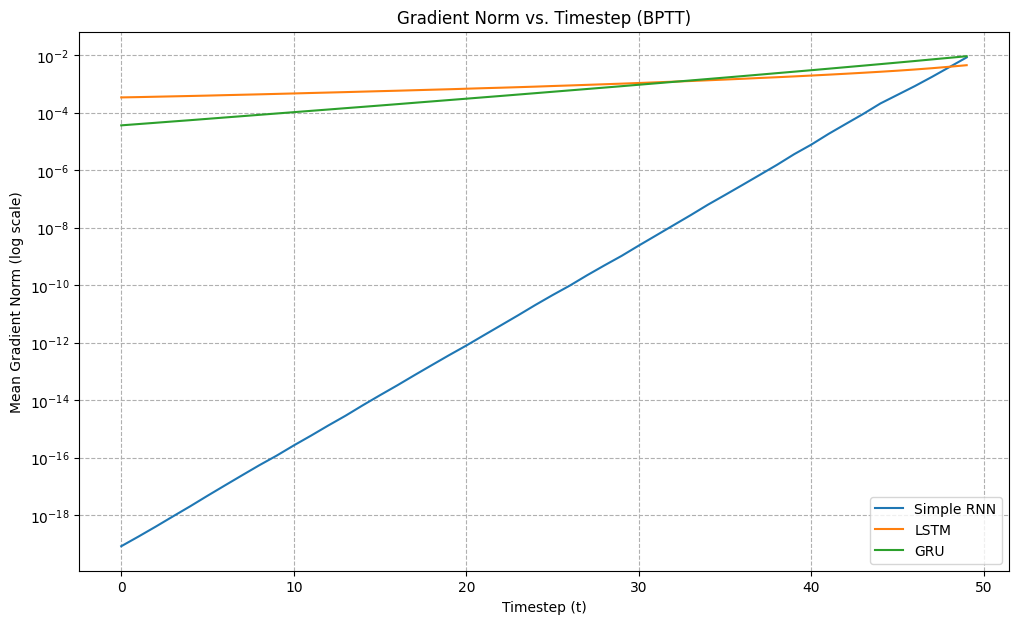

In [11]:
# Plot out the thing as a line graph
plt.figure(figsize=(12, 7))
for model_name, grads in viz_data.items():
    plt.plot(grads, label=model_name)

plt.title("Gradient Norm vs. Timestep (BPTT)")
plt.xlabel("Timestep (t)")
plt.ylabel("Mean Gradient Norm (log scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

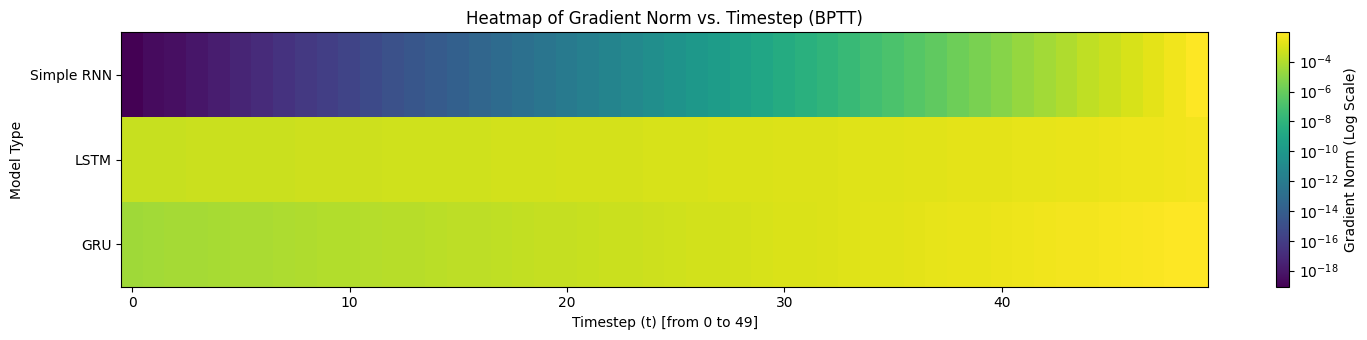

In [12]:
# Get the data from our viz_data dictionary
model_names = list(viz_data.keys())
grad_data = np.array([viz_data[name] for name in model_names])

# We must clip at a very small value to avoid log(0)
# We can use the smallest non-zero value we found as the min
min_val = np.min(grad_data[np.nonzero(grad_data)])
grad_data_clipped = np.clip(grad_data, a_min=min_val, a_max=None)

# Create a heatmap
fig, ax = plt.subplots(figsize=(15, 3.5))

# We plot this under LogNorm
im = ax.imshow(
    grad_data_clipped,
    aspect="auto",
    cmap="viridis",
    norm=mcolors.LogNorm(vmin=grad_data_clipped.min(), vmax=grad_data_clipped.max()),
)

# Set the Y-axis labels
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(model_names)

# Set labels and title
ax.set_xlabel("Timestep (t) [from 0 to 49]")
ax.set_ylabel("Model Type")
ax.set_title("Heatmap of Gradient Norm vs. Timestep (BPTT)")

cbar = fig.colorbar(im)
cbar.set_label("Gradient Norm (Log Scale)")

plt.tight_layout()
plt.show()

## Takeaways?

Well, if you look at the logs of the training loop, you'll see that `Embedding Grad @ t=0` gets really, really small. This is because of the vanishing gradient phenomenon that we talked about.

In fact, you can see it happen across timesteps by looking at the two diagrams above (I find the heatmap clearest personally), see how for LSTMs and GRUs, their gradients tended to stay fairly stable across timesteps, while for a simple RNN, that gradient from `t=49` slowly dissipates over time as it gets to `t=0`.
